# CNN Model (filtered)

This code is an adaptation of the CNN model provided by Professor Jorge Henriques in the course slides, the CNN model developed for another course (available at https://github.com/leosousa200/RetinopathyAlgorithm), a guide to multi-input CNN provided by Keras (available at https://keras.io/guides/functional_api/) and a CNN model available on Kaggle (at https://www.kaggle.com/code/vishwasgpai/guide-for-creating-cnn-model-using-csv-file/notebook).

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Concatenate

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Import and Organize Data

In [5]:
numeric = pd.read_csv("COVID_numerics.csv").values
images  = pd.read_csv("COVID_IMG.csv",header=None).values # avoids ignoring first line!

X_num = numeric[:,0:8] # 8 columns (GENDER,AGE,MARITAL STATUS,VACINATION,RESPIRATION CLASS,HEART RATE,SYSTOLIC BLOOD PRESSURE,TEMPERATURE)
T = numeric[:,8] # Target
X_img = images[:,:] # each line represents a 21x21 image

t0 = np.sum(T==0)
t1 = np.sum(T==1)
print(f"Number of cases with T=0: {t0}")
print(f"Number of cases with T=1: {t1}")

# After running the DecisionTree model, we found that AGE, MARITAL STATUS, HEART RATE, and SYSTOLIC BLOOD PRESSURE had low to no importance.
# Therefore, we can remove them from our dataset.
toremove = [1,2,5,6]  # Remove a segunda e a quarta coluna (índices 1 e 3)
X_num = np.delete(X_num, toremove, axis=1)

Number of cases with T=0: 407
Number of cases with T=1: 193


### Reshape Image Data (21x21)

In [11]:
X_img = X_img.reshape(X_img.shape[0],21,21,1) # resize images into 21x21x1

### Train-Test Split

In [12]:
X_img_train, X_img_test, X_num_train, X_num_test, T_train, T_test = train_test_split(X_img, X_num, T, test_size=0.3, random_state=42)

### Model

In [13]:
numeric_input = Input(shape=(X_num.shape[1],))
image_input = Input(shape=(21,21,1))

# CNN Path Only for the Images
x_img = Conv2D(64, (3, 3), activation='relu')(image_input)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Conv2D(32, (3, 3), activation='relu')(x_img)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Flatten()(x_img)

# MLP Path Only for Numerical Data
x_num = Dense(64, activation='relu')(numeric_input)

# Concatenate Outputs
concatenated = Concatenate()([x_img, x_num])

# Final Output Dense Layer
output = Dense(1,activation='sigmoid')(concatenated) # this is a binary classification problem, so we can use the Sigmoid activation function

model = Model(inputs=[image_input,numeric_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 21, 21, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 19, 19,    │        640 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 9, 9, 64)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 32)  │     18,464 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 3, 3, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 288)       │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        320 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 352)       │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        353 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,777 (77.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [14]:
history = model.fit([X_img_train, X_num_train], T_train, epochs=12, batch_size=64)
print("Loss: ", history.history['loss'])

train = model.predict([X_img_train, X_num_train]).round()

Epoch 1/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6638 - loss: 0.6219
Epoch 2/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6573 - loss: 0.5703
Epoch 3/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7132 - loss: 0.5246
Epoch 4/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7643 - loss: 0.4815
Epoch 5/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7774 - loss: 0.4820
Epoch 6/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8198 - loss: 0.4239
Epoch 7/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8087 - loss: 0.4315
Epoch 8/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8089 - loss: 0.4275
Epoch 9/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7768 - loss: 0.4495
Epoch 10/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7842 - loss: 0.4359
Epoch 11/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7770 - loss: 0.4403
Epoch 12/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7833 - loss: 0.4333
L

### Test Model

In [15]:
Ytest = model.predict([X_img_test, X_num_test]).round()
scores = model.evaluate([X_img_test, X_num_test], T_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Baseline Error: 21.67%


### Evaluate Model

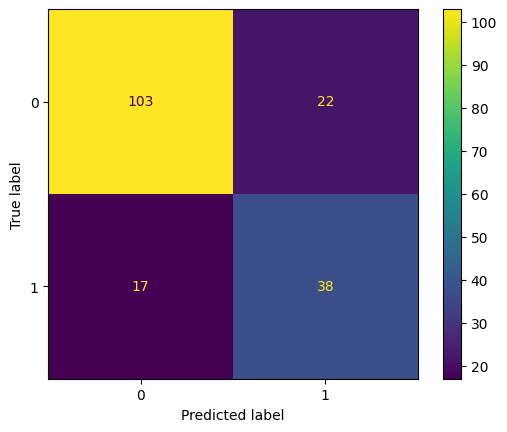

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       125
         1.0       0.63      0.69      0.66        55

    accuracy                           0.78       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.79      0.78      0.79       180



In [16]:
cm = confusion_matrix(T_test, Ytest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(T_test,Ytest))